In [4]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 57.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [5]:
!pip install ncps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.2 MB/s eta 0:00:00


#  Dependecies

In [6]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns


## Ozone


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/eighthr.data -P data/ozone/
import os
os.makedirs('data/ozone', exist_ok=True)

--2025-03-25 13:31:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/eighthr.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data/ozone/eighthr.data’

eighthr.data            [ <=>                ] 799.15K  --.-KB/s    in 0.06s   

2025-03-25 13:31:33 (12.7 MB/s) - ‘data/ozone/eighthr.data’ saved [818329]



In [ ]:
def to_float(v):
    if(v == "?"):
        return 0
    else:
        return float(v)

def load_trace():
    all_x = []
    all_y = []

    with open("data/ozone/eighthr.data","r") as f:
        miss = 0
        total = 0
        while True:
            line = f.readline()
            if(line is None):
                break
            line = line[:-1]
            parts = line.split(',')

            total+=1
            for i in range(1,len(parts)-1):
                if(parts[i]=="?"):
                    miss+=1
                    break

            if(len(parts)!=74):
                break
            label = int(float(parts[-1]))
            feats = [to_float(parts[i]) for i in range(1,len(parts)-1)]

            all_x.append(np.array(feats))
            all_y.append(label)
    print("Missing features in {} out of {} samples ({:0.2f})".format(miss,total,100*miss/total))
    print("Read {} lines".format(len(all_x)))
    all_x = np.stack(all_x,axis=0)
    all_y = np.array(all_y)

    print("Imbalance: {:0.2f}%".format(100*np.mean(all_y)))
    all_x -= np.mean(all_x) #normalize
    all_x /= np.std(all_x) #normalize

    return all_x,all_y


def cut_in_sequences(x,y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0,x.shape[0] - seq_len,inc):
        start = s
        end = start+seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)


class OzoneData:

    def __init__(self,seq_len=32):

        x,y = load_trace()

        train_x,train_y = cut_in_sequences(x,y,seq_len,inc=4)

        self.train_x = np.stack(train_x,axis=1)
        self.train_y = np.stack(train_y,axis=1)

        total_seqs = self.train_x.shape[1]
        print("Total number of sequences: {}".format(total_seqs))
        permutation = np.random.RandomState(23489).permutation(total_seqs)
        valid_size = int(0.1*total_seqs)
        test_size = int(0.15*total_seqs)

        self.valid_x = self.train_x[:,permutation[:valid_size]]
        self.valid_y = self.train_y[:,permutation[:valid_size]]
        self.test_x = self.train_x[:,permutation[valid_size:valid_size+test_size]]
        self.test_y = self.train_y[:,permutation[valid_size:valid_size+test_size]]
        self.train_x = self.train_x[:,permutation[valid_size+test_size:]]
        self.train_y = self.train_y[:,permutation[valid_size+test_size:]]

        # self.train_x = np.transpose(train_x, (1, 0, 2)).astype(np.float32)  # (num_sequences, seq_len, 72)
        # self.train_y = np.transpose(train_y, (1, 0))[:, :, np.newaxis].astype(np.float32)  # (num_sequences, seq_len, 1)

        # self.valid_x = np.transpose(self.valid_x, (1, 0, 2)).astype(np.float32)
        # self.valid_y = np.transpose(self.valid_y, (1, 0))[:, :, np.newaxis].astype(np.float32)

        # self.test_x = np.transpose(self.test_x, (1, 0, 2)).astype(np.float32)
        # self.test_y = np.transpose(self.test_y, (1, 0))[:, :, np.newaxis].astype(np.float32)



    def iterate_train(self,batch_size=16):
        total_seqs = self.train_x.shape[1]
        permutation = np.random.permutation(total_seqs)
        total_batches = total_seqs // batch_size

        for i in range(total_batches):
            start = i*batch_size
            end = start + batch_size
            batch_x = self.train_x[:,permutation[start:end]]
            batch_y = self.train_y[:,permutation[start:end]]
            yield (batch_x,batch_y)

In [ ]:
ozone_ds = OzoneData()

Missing features in 687 out of 2535 samples (27.10)
Read 2534 lines
Imbalance: 6.31%
Total number of sequences: 32


In [ ]:
# ozone_ds.train_x = ozone_ds.train_x.transpose(1, 0, 2)
# ozone_ds.train_y = ozone_ds.train_y.transpose(1, 0)

# ozone_ds.test_x = ozone_ds.test_x.transpose(1, 0, 2)
# ozone_ds.test_y = ozone_ds.test_y.transpose(1, 0)

# ozone_ds.valid_x = ozone_ds.valid_x.transpose(1, 0, 2)
# ozone_ds.valid_y = ozone_ds.valid_y.transpose(1, 0)

In [ ]:
print(ozone_ds.train_x.shape)
print(ozone_ds.train_y.shape)
print(ozone_ds.test_x.shape)
print(ozone_ds.test_y.shape)
print(ozone_ds.valid_x.shape)
print(ozone_ds.valid_y.shape)
# ozone_ds.train_y.shape

(626, 25, 72)
(626, 25)
(626, 4, 72)
(626, 4)
(626, 3, 72)
(626, 3)


In [ ]:

# Convert data to double precision
ozone_ds.train_x = ozone_ds.train_x.astype(np.float64)
ozone_ds.train_y = ozone_ds.train_y.astype(np.float64)
ozone_ds.valid_x = ozone_ds.valid_x.astype(np.float64)
ozone_ds.valid_y = ozone_ds.valid_y.astype(np.float64)
ozone_ds.test_x = ozone_ds.test_x.astype(np.float64)
ozone_ds.test_y = ozone_ds.test_y.astype(np.float64)

# Create TensorDataset with double precision tensors
train_dataset = data.TensorDataset(
    torch.from_numpy(ozone_ds.train_x).double(),
    torch.from_numpy(ozone_ds.train_y).double()
)
valid_dataset = data.TensorDataset(
    torch.from_numpy(ozone_ds.valid_x).double(),
    torch.from_numpy(ozone_ds.valid_y).double()
)
test_dataset = data.TensorDataset(
    torch.from_numpy(ozone_ds.test_x).double(),
    torch.from_numpy(ozone_ds.test_y).double()
)

batch_size = 16
train_loader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False,
)
valid_loader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False,
)
test_loader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
)

# Adjust model parameters for the new dataset
in_features = 72  # Number of input features
out_features = 1  # Output (regression target)

In [ ]:
X_train = ozone_ds.train_x
y_train = ozone_ds.train_y

X_test  = ozone_ds.test_x
y_test  = ozone_ds.test_y

X_val   = ozone_ds.valid_x
y_val   = ozone_ds.valid_y

print(f"type of data: {type(X_train)}")

type of data: <class 'numpy.ndarray'>


In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test =  torch.tensor(X_test , dtype=torch.float32)
y_test =  torch.tensor(y_test , dtype=torch.float32)
X_val =   torch.tensor(X_val  , dtype=torch.float32)
y_val =   torch.tensor(y_val  , dtype=torch.float32)
print(f"type of data: {type(X_train)}")

type of data: <class 'torch.Tensor'>


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Create DataLoader (batching still happens on GPU)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle validation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle test


## Occupancy dataset

In [ ]:
import os
import zipfile
import requests

# Create the directory if it doesn't exist
os.makedirs('data/occupancy', exist_ok=True)

# Download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip"
response = requests.get(url)

# Save the downloaded zip file
with open('occupancy_data.zip', 'wb') as file:
    file.write(response.content)

# Unzip the file
with zipfile.ZipFile('occupancy_data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/occupancy')

# Clean up the zip file
os.remove('occupancy_data.zip')

# Verify the file structure
print("Contents of data directory:")
for root, dirs, files in os.walk('data/occupancy'):
    for file in files:
        print(os.path.join(root, file))


Contents of data directory:
data/occupancy/datatest.txt
data/occupancy/datatraining.txt
data/occupancy/datatest2.txt


The original dataset consists of a pre-defined training and test set. We used the binary classification accuracy as the perfor
mance metric. We cut the sequences of each of the two sets into a training and test set of overlapping sub-sequences of exactly
 32 time-steps. Note that no item from the test set was leaking into the training set during this process. Input features of all
 data were normalized by the mean and standard deviation of the training set, such that the training set has zero mean and unit
 standard deviation. We select 10% of the training set as the validation set.

In [ ]:
import pandas as pd
def read_file(filename):
    df = pd.read_csv(filename)

    data_x = np.stack([
        df['Temperature'].values,
        df['Humidity'].values,
        df['Light'].values,
        df['CO2'].values,
        df['HumidityRatio'].values,
        ],axis=-1)
    data_y = df['Occupancy'].values.astype(np.int32)
    return data_x,data_y

def cut_in_sequences(x,y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0,x.shape[0] - seq_len,inc):
        start = s
        end = start+seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)

class OccupancyData:
    def __init__(self, seq_len=16):
        train_x, train_y = read_file("data/occupancy/datatraining.txt")
        test0_x, test0_y = read_file("data/occupancy/datatest.txt")
        test1_x, test1_y = read_file("data/occupancy/datatest2.txt")

        # Normalize
        mean_x = np.mean(train_x, axis=0)
        std_x = np.std(train_x, axis=0)
        train_x = (train_x - mean_x) / std_x
        test0_x = (test0_x - mean_x) / std_x
        test1_x = (test1_x - mean_x) / std_x

        # Cut into sequences
        train_x, train_y = cut_in_sequences(train_x, train_y, seq_len)
        test0_x, test0_y = cut_in_sequences(test0_x, test0_y, seq_len, inc=8)
        test1_x, test1_y = cut_in_sequences(test1_x, test1_y, seq_len, inc=8)

        # Split into train/valid
        permutation = np.random.RandomState(893429).permutation(train_x.shape[1])
        valid_size = int(0.1 * train_x.shape[1])
        self.valid_x = train_x[:, permutation[:valid_size]]
        self.valid_y = train_y[:, permutation[:valid_size]]
        self.train_x = train_x[:, permutation[valid_size:]]
        self.train_y = train_y[:, permutation[valid_size:]]

        # Concatenate test data
        self.test_x = np.concatenate([test0_x, test1_x], axis=1)
        self.test_y = np.concatenate([test0_y, test1_y], axis=1)

        print("Original train_x shape:", train_x.shape)  # Should be (seq_len, num_sequences, 5)
        print("Original train_y shape:", train_y.shape)  # Should be (seq_len, num_sequences)

        # Transpose and reshape for PyTorch compatibility
        self.train_x = np.transpose(train_x, (1, 0, 2)).astype(np.float32)  # (num_sequences, seq_len, 5)
        self.train_y = np.transpose(train_y, (1, 0))[:, :, np.newaxis].astype(np.float32)  # (num_sequences, seq_len, 1)

        self.valid_x = np.transpose(self.valid_x, (1, 0, 2)).astype(np.float32)
        self.valid_y = np.transpose(self.valid_y, (1, 0))[:, :, np.newaxis].astype(np.float32)

        self.test_x = np.transpose(self.test_x, (1, 0, 2)).astype(np.float32)
        self.test_y = np.transpose(self.test_y, (1, 0))[:, :, np.newaxis].astype(np.float32)

        print("Transposed train_x shape:", self.train_x.shape)  # Should be (seq_len, num_sequences, 5)
        print("Transposed train_y shape:", self.train_y.shape)  # Should be (seq_len, num_sequences)


In [ ]:
occupancy = OccupancyData(seq_len=32) # 32 time-steps in each of 8111 sequences
# Check for NaNs or infinities in your data
assert not np.any(np.isnan(occupancy.train_x)), "Data contains NaN values!"
assert not np.any(np.isinf(occupancy.train_x)), "Data contains infinite values!"


Original train_x shape: (32, 8111, 5)
Original train_y shape: (32, 8111)
Transposed train_x shape: (8111, 32, 5)
Transposed train_y shape: (8111, 32, 1)


In [ ]:
X_train = occupancy.train_x
y_train = occupancy.train_y
X_test  = occupancy.test_x
y_test  = occupancy.test_y
X_val   = occupancy.valid_x
y_val   = occupancy.valid_y

print(f"type of data: {type(X_train)}")


type of data: <class 'numpy.ndarray'>


In [ ]:
print(occupancy.train_x.dtype,
occupancy.train_y.dtype,
occupancy.test_x.dtype,
occupancy.test_y.dtype,
occupancy.valid_x.dtype,
occupancy.valid_y.dtype)

float32 float32 float32 float32 float32 float32


In [ ]:
# convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test =  torch.tensor(X_test , dtype=torch.float32)
y_test =  torch.tensor(y_test , dtype=torch.float32)
X_val =   torch.tensor(X_val  , dtype=torch.float32)
y_val =   torch.tensor(y_val  , dtype=torch.float32)
print(f"type of data: {type(X_train)}")

type of data: <class 'torch.Tensor'>


In [ ]:
# move to gpu if possible
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("device selected: cuda")
else:
    device = torch.device('cpu')
    print("device selected: cpu")

X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)


device selected: cuda


In [ ]:

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Create DataLoader (batching still happens on GPU)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle validation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle test


## Traffic

In [11]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz

--2025-03-25 21:55:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Metro_Interstate_Traffic_Volume.csv.gz’

Metro_Interstate_Tr     [  <=>               ] 395.87K  1.16MB/s    in 0.3s    

2025-03-25 21:55:15 (1.16 MB/s) - ‘Metro_Interstate_Traffic_Volume.csv.gz’ saved [405373]



In [12]:
!gunzip /content/Metro_Interstate_Traffic_Volume.csv.gz

In [22]:
import pandas as pd
import datetime as dt

def load_trace():
    df = pd.read_csv("/content/Metro_Interstate_Traffic_Volume.csv")
    holiday = (df["holiday"].values == None).astype(np.float32)
    temp = df["temp"].values.astype(np.float32)
    temp -= np.mean(temp)  # normalize temp by annual mean
    rain = df["rain_1h"].values.astype(np.float32)
    snow = df["snow_1h"].values.astype(np.float32)
    clouds = df["clouds_all"].values.astype(np.float32)
    date_time = df["date_time"].values
    # 2012-10-02 13:00:00
    date_time = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in date_time]
    weekday = np.array([d.weekday() for d in date_time]).astype(np.float32)
    noon = np.array([d.hour for d in date_time]).astype(np.float32)
    noon = np.sin(noon * np.pi / 24)

    features = np.stack([holiday, temp, rain, snow, clouds, weekday, noon], axis=-1)

    traffic_volume = df["traffic_volume"].values.astype(np.float32)
    traffic_volume -= np.mean(traffic_volume)  # normalize
    traffic_volume /= np.std(traffic_volume)  # normalize

    return features, traffic_volume


def cut_in_sequences(x, y, seq_len, inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0, x.shape[0] - seq_len, inc):
        start = s
        end = start + seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x, axis=1), np.stack(sequences_y, axis=1)


class TrafficData:
    def __init__(self, seq_len=32):

        x, y = load_trace()

        train_x, train_y = cut_in_sequences(x, y, seq_len, inc=4)

        self.train_x = np.stack(train_x, axis=0)
        self.train_y = np.stack(train_y, axis=0)
        total_seqs = self.train_x.shape[1]
        print("Total number of training sequences: {}".format(total_seqs))
        permutation = np.random.RandomState(23489).permutation(total_seqs)
        valid_size = int(0.1 * total_seqs)
        test_size = int(0.15 * total_seqs)

        self.valid_x = self.train_x[:, permutation[:valid_size]]
        self.valid_y = self.train_y[:, permutation[:valid_size]]
        self.test_x = self.train_x[:, permutation[valid_size : valid_size + test_size]]
        self.test_y = self.train_y[:, permutation[valid_size : valid_size + test_size]]
        self.train_x = self.train_x[:, permutation[valid_size + test_size :]]
        self.train_y = self.train_y[:, permutation[valid_size + test_size :]]

        self.train_x = np.transpose(train_x, (1, 0, 2)).astype(np.float32)  # (num_sequences, seq_len, 5)
        self.train_y = np.transpose(train_y, (1, 0))[:, :, np.newaxis].astype(np.float32)  # (num_sequences, seq_len, 1)

        self.valid_x = np.transpose(self.valid_x, (1, 0, 2)).astype(np.float32)
        self.valid_y = np.transpose(self.valid_y, (1, 0))[:, :, np.newaxis].astype(np.float32)

        self.test_x = np.transpose(self.test_x, (1, 0, 2)).astype(np.float32)
        self.test_y = np.transpose(self.test_y, (1, 0))[:, :, np.newaxis].astype(np.float32)

    def iterate_train(self, batch_size=16):
        total_seqs = self.train_x.shape[1]
        permutation = np.random.permutation(total_seqs)
        total_batches = total_seqs // batch_size

        for i in range(total_batches):
            start = i * batch_size
            end = start + batch_size
            batch_x = self.train_x[:, permutation[start:end]]
            batch_y = self.train_y[:, permutation[start:end]]
            yield (batch_x, batch_y)

In [23]:
traffic = TrafficData()

Total number of training sequences: 12043


In [24]:
print(traffic.train_x.shape)
print(traffic.train_y.shape)

print(traffic.valid_x.shape)
print(traffic.valid_y.shape)

print(traffic.test_x.shape)
print(traffic.test_y.shape)

(12043, 32, 7)
(12043, 32, 1)
(1204, 32, 7)
(1204, 32, 1)
(1806, 32, 7)
(1806, 32, 1)


In [27]:
# convert to tensors
X_train = torch.tensor(traffic.train_x, dtype=torch.float32)
y_train = torch.tensor(traffic.train_y, dtype=torch.float32)
X_test =  torch.tensor(traffic.test_x , dtype=torch.float32)
y_test =  torch.tensor(traffic.test_y , dtype=torch.float32)
X_val =   torch.tensor(traffic.valid_x  , dtype=torch.float32)
y_val =   torch.tensor(traffic.valid_y  , dtype=torch.float32)
print(f"type of data: {type(X_train)}")

type of data: <class 'torch.Tensor'>


In [33]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Create DataLoader (batching still happens on GPU)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle validation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle test

In [60]:
t_l = test_loader.dataset[0][1]
t_l.shape

torch.Size([32, 1])

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

# LightningModule for training an RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.001):
        """
        :param model: The PyTorch model to train.
        :param loss_fn: Loss function (e.g., nn.MSELoss(), nn.CrossEntropyLoss()).
        :param lr: Learning rate.
        """
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss
        # Initialize empty lists to store predictions and labels during the test
        self.preds = []
        self.labels = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits, _ = self.model.forward(x) # Model output (logits)
        y_hat = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
        # Compute loss
        loss = self.loss_fn(y_hat.view(-1), y.view(-1))
        # Log the loss
        self.log("train_loss", loss, prog_bar=True)

        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits, _ = self.model.forward(x) # Model output (logits)
        y_hat = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
        # Compute loss
        loss = self.loss_fn(y_hat.view(-1), y.view(-1))
        # Log the loss
        self.log("val_loss", loss, prog_bar=True)
        return {"loss": loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits, _ = self.model.forward(x) # Model output (logits)
        y_hat = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
        loss = self.loss_fn(y_hat.view(-1), y.view(-1))
        # Store predictions and true labels in memory (list)
        self.preds.append(y_hat.cpu())  # Use .cpu() to store them on the CPU if they're on GPU
        self.labels.append(y.cpu())  # Similarly, move labels to CPU
        return {"loss": loss}


    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

class SequenceLearnerMSE(pl.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = nn.MSELoss()  # Changed to MSE Loss
        self.preds = []
        self.labels = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits, _ = self.model(x)
        y_hat = logits.view(-1)  # Removed sigmoid
        loss = self.loss_fn(y_hat, y.view(-1))
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits, _ = self.model(x)
        y_hat = logits.view(-1)  # Removed sigmoid
        loss = self.loss_fn(y_hat, y.view(-1))
        self.log("val_loss", loss, prog_bar=True)
        return {"loss": loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits, _ = self.model(x)
        y_hat = logits.view(-1)  # Removed sigmoid
        loss = self.loss_fn(y_hat, y.view(-1))
        self.preds.append(y_hat.detach().cpu())
        self.labels.append(y.cpu())
        return {"loss": loss}

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)


In [34]:
# Adjust model parameters for the new dataset
in_features = 7  # Number of input features
out_features = 1  # Output (binary classification target)

Here we can finally create a LTCCell and make use of the predefined sparse wiring structures of the keras-ncp package. For simplicity we will just define a fully-connected RNN

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
wiring = AutoNCP(units=32, output_size=out_features) # for BCELoss we need logit of size 1
ltc_model = LTC(input_size=in_features, units=wiring).to(device)

learn = SequenceLearnerMSE(ltc_model, lr=0.005)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=7,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [71]:
len(train_loader.dataset)

12043

In [72]:
trainer.fit(learn, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | LTC     | 6.4 K  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
5.1 K     Trainable params
1.2 K     Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


In [61]:
len(test_loader.dataset)

1806

In [73]:
learn.preds =[]
learn.labels =[]
trainer.test(learn, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]

In [46]:
preds = learn.preds[0]

preds

tensor([ 0.4240,  0.2095, -0.1355,  ...,  0.7456,  0.7443,  0.7471])

In [74]:
preds = []
for i_batch in range(len(learn.preds)):
    for i_sequence in range(len(learn.preds[i_batch])):
        preds.append(float(learn.preds[i_batch][i_sequence]))
len(preds)

57792

In [75]:
labels = []
for i_batch in range(len(learn.labels)):
    for i_sequence in range(len(learn.labels[i_batch])):
        labels += learn.labels[i_batch][i_sequence]
len(labels)

57792

In [67]:
labels[0].shape

torch.Size([32, 1])

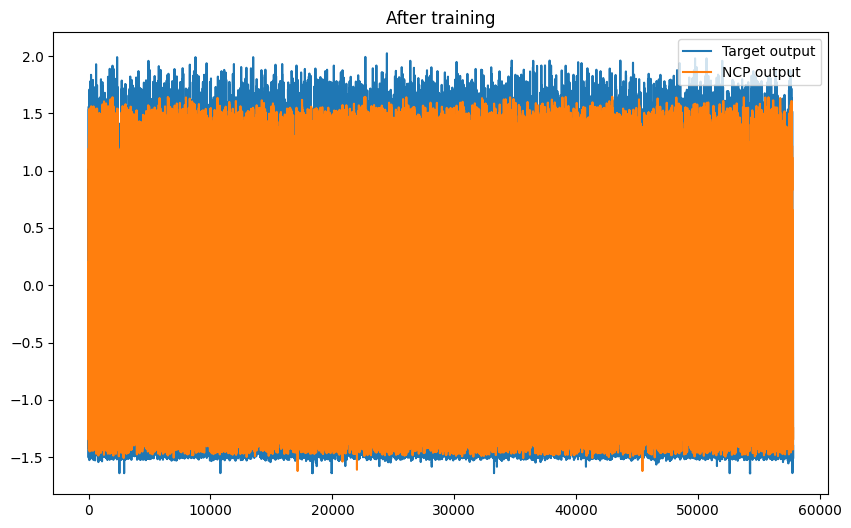

In [76]:

plt.figure(figsize=(10, 6))
# Plot first sequence
plt.plot(labels, label="Target output")
plt.plot(preds, label="NCP output")
#plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

In [78]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

f1 = f1_score(labels, preds)
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)

ValueError: continuous is not supported